# Задание 1.

Для СЛАУ с некоторой матрицей A:
- вычислить числа обусловленности;
- поварьировав матрицу и правую часть (например, на 1e-2 – 1e-10), вычислить |x − ˜x|;
- посмотреть, есть ли корреляция между величинами чисел обусловленности и погрешностью решения.

**Отчёт**: https://docs.google.com/document/d/1HARJ3_7dv383VXmcq0H2jY6VepuM-nqx8gxeuqSi4bA/edit?usp=sharing

# Imports

In [1]:
from functools import reduce
from math import sqrt
from typing import Iterable, Callable, List

import matplotlib.pyplot as plt
import numpy as np
import nbimporter

from common import is_close, generate_hilberts_matrix_element, generate_tridiagonal_matrix_element

# Solution

In [2]:
epsilon = 1e-9

In [3]:
class ConditionNumbers:
    def __init__(self, spectral: float, volume: float, angular: float):
        self.spectral = spectral
        self.volume = volume
        self.angular = angular

    def __repr__(self):
        return f"ConditionNumbers(spectral={self.spectral}, volume={self.volume}, angular={self.angular})"

    def __eq__(self, other):
        if not isinstance(other, ConditionNumbers):
            return NotImplemented
            
        return (is_close(self.spectral, other.spectral, epsilon) and 
                is_close(self.volume, other.volume, epsilon) and
                is_close(self.angular, other.angular, epsilon))


def calculate_condition_numbers(A: np.ndarray) -> ConditionNumbers:
    if A.shape[0] != A.shape[1]:
        raise ValueError("Matrix A must be square")
    
    if not np.linalg.det(A):
        return ConditionNumbers(float('inf'), float('inf'), float('inf'))

    A_inverse = np.linalg.inv(A)

    spectral = np.linalg.cond(A)

    volume = reduce(lambda m, row: m * sqrt(reduce(lambda s, element: s + element ** 2, row, 0)),
                    A, 1) / abs(np.linalg.det(A))

    angular = max([np.linalg.norm(A[n]) * np.linalg.norm(A_inverse[:, n]) for n in range(A.shape[0])])

    return ConditionNumbers(spectral, volume, angular)

# Tests

#### Test with singular matrix

In [4]:
A = np.array([[2, 4, 6, 8], [4, 8, 12, 16], [1, 27, -63, 0.5], [11.67, -10.19, -19.871, 0.12]])
expected_result = ConditionNumbers(float('inf'), float('inf'), float('inf'))
result = calculate_condition_numbers(A)
assert result == expected_result, f"Singular matrix is expected to have all the condition numbers equal to inf. Expected {expected_result} but got {result}"

#### Test with matrix of dimension 1

In [5]:
A = np.array([[777]])
expected_result = ConditionNumbers(1, 1, 1)
result = calculate_condition_numbers(A)
assert result == expected_result, f"1-d matrix expected to have all the condition numbers equal to 1. Expected {expected_result} but got {result}"

#### Test with Hilbert's matrix of dimension 20

In [6]:
A = np.array([[generate_hilberts_matrix_element(row, column) for column in range(20)] for row in range(20)])
expected_value = 10**4
result_spectral = calculate_condition_numbers(A).spectral
assert result_spectral > expected_value, f"Hilbert's matrices are expected to have a large spectral number. Expected value > {expected_value} but got {result_spectral}"

#### Test with a random matrix which condition numbers were pre-calculated

In [7]:
A = np.array([[2, 0.5, 1.25], [10, -1.56, -5.68], [-2.5, 4.72, -8.54]])
expected_result = ConditionNumbers(
    7.6066573478,
    1.5301801764, 
    1.5155189302
)
result = calculate_condition_numbers(A)
assert result == expected_result, f"Expected {expected_result} but got {result}"

# Experiments

In [8]:
class ExperimentResult:
    def __init__(self, error_norm, condition_numbers):
        self.error_norm = error_norm
        self.condition_numbers = condition_numbers


def run_experiment(dimension: int, decimal_orders: Iterable, generate: Callable, num_trials: int) -> List:
    results = []

    A = np.array([[generate(row, column) for column in range(dimension)] for row in range(dimension)])
    x = np.ones(dimension)
    b = A.dot(x)

    for order in decimal_orders:
        avg_error_norm = 0
        avg_condition_numbers = None

        # smoothing
        for _ in range(num_trials):
            perturbation_A = np.random.uniform(-10**-order, 10**-order, A.shape)
            perturbation_b = np.random.uniform(-10**-order, 10**-order, b.shape)
            
            A_perturbed = A + perturbation_A
            b_perturbed = b + perturbation_b
            
            condition_numbers = calculate_condition_numbers(A_perturbed)
            error_norm = np.linalg.norm(x - np.linalg.solve(A_perturbed, b_perturbed))
            
            avg_error_norm += error_norm
            
            if avg_condition_numbers is None:
                avg_condition_numbers = condition_numbers
            else:
                avg_condition_numbers.spectral += condition_numbers.spectral
                avg_condition_numbers.volume += condition_numbers.volume
                avg_condition_numbers.angular += condition_numbers.angular

        avg_error_norm /= num_trials
        avg_condition_numbers.spectral /= num_trials
        avg_condition_numbers.volume /= num_trials
        avg_condition_numbers.angular /= num_trials
        
        result = ExperimentResult(avg_error_norm, avg_condition_numbers)
        
        results.append(result)

    return results


def plot_experiment_results(dimension, decimal_orders, generate, num_trials):
    results = run_experiment(dimension, decimal_orders, generate, num_trials)
    
    error_norms = [result.error_norm for result in results]
    spectral_condition_numbers = [result.condition_numbers.spectral for result in results]
    volume_condition_numbers = [result.condition_numbers.volume for result in results]
    angular_condition_numbers = [result.condition_numbers.angular for result in results]

    plt.figure(figsize=(10, 6))
    plt.loglog(spectral_condition_numbers, error_norms, 'r-', label='Spectral')
    plt.ylabel('Average ||x - x_perturbed||')
    plt.xlabel('Average Spectral Condition Number Size')
    plt.legend()
    plt.title('Average Spectral Condition Number vs. Average ||x - x_perturbed||')
    plt.grid(True, which="both", ls="--")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.loglog(volume_condition_numbers, error_norms, 'g-', label='Volume')
    plt.ylabel('Average ||x - x_perturbed||')
    plt.xlabel('Average Volume Condition Number Size')
    plt.legend()
    plt.title('Average Volume Condition Number vs. Average ||x - x_perturbed||')
    plt.grid(True, which="both", ls="--")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.loglog(angular_condition_numbers, error_norms, 'b-', label='Angular')
    plt.ylabel('Average ||x - x_perturbed||')
    plt.xlabel('Average Angular Condition Number Size')
    plt.legend()
    plt.title('Average Angular Condition Number vs. Average ||x - x_perturbed||')
    plt.grid(True, which="both", ls="--")
    plt.show()

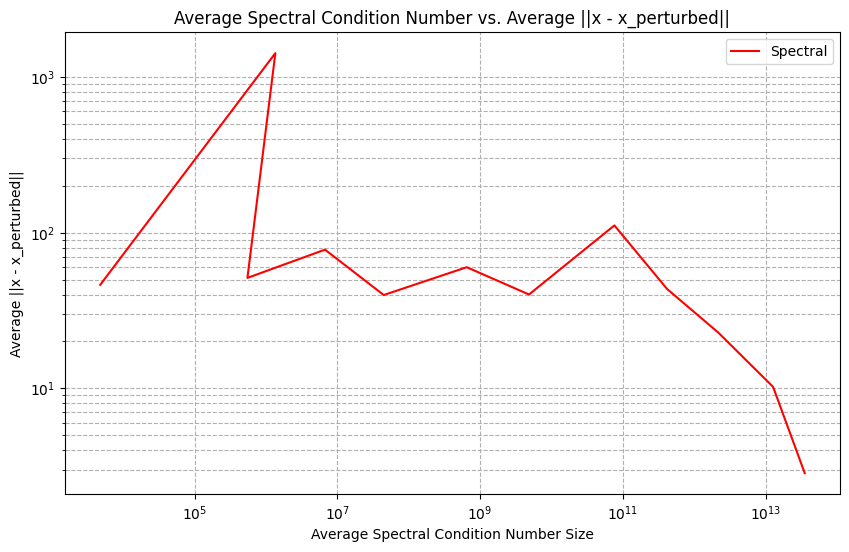

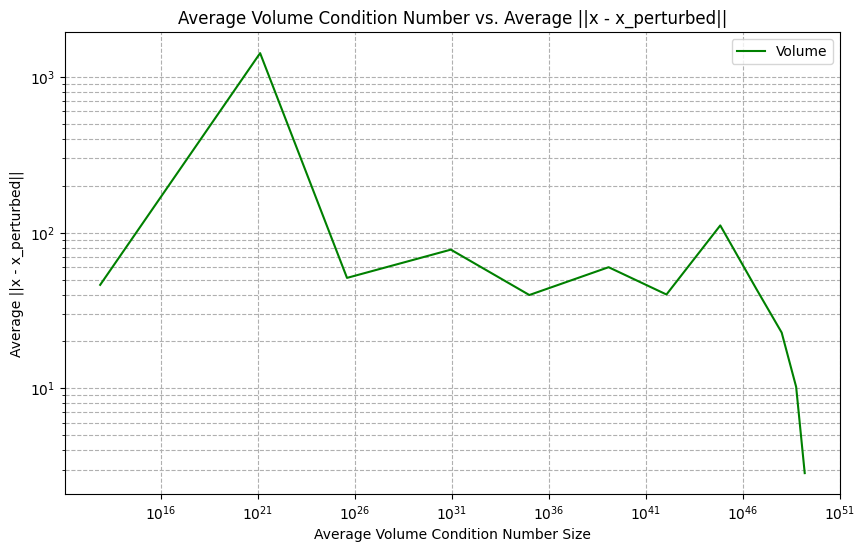

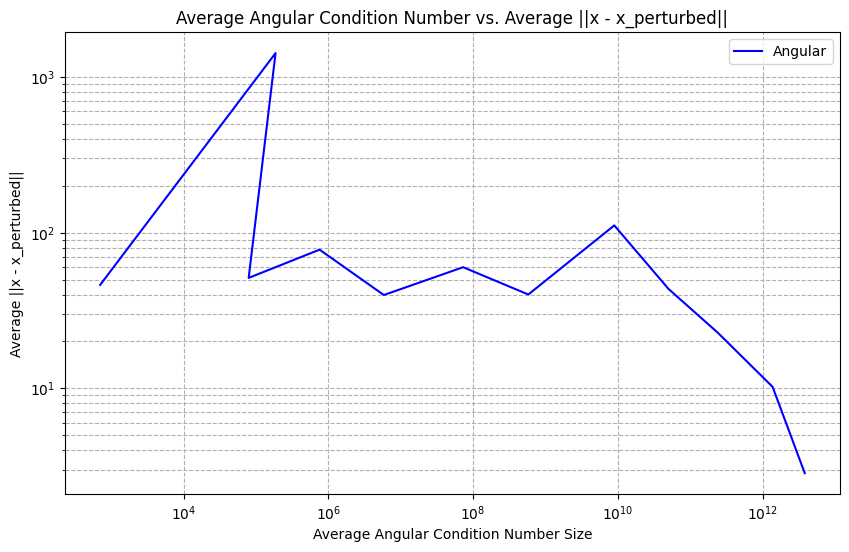

In [9]:
matrix_dimension = 10
decimal_orders = range(2, 14)
matrix_generator =  generate_hilberts_matrix_element
num_trials = 1000

plot_experiment_results(matrix_dimension, decimal_orders, matrix_generator, num_trials)

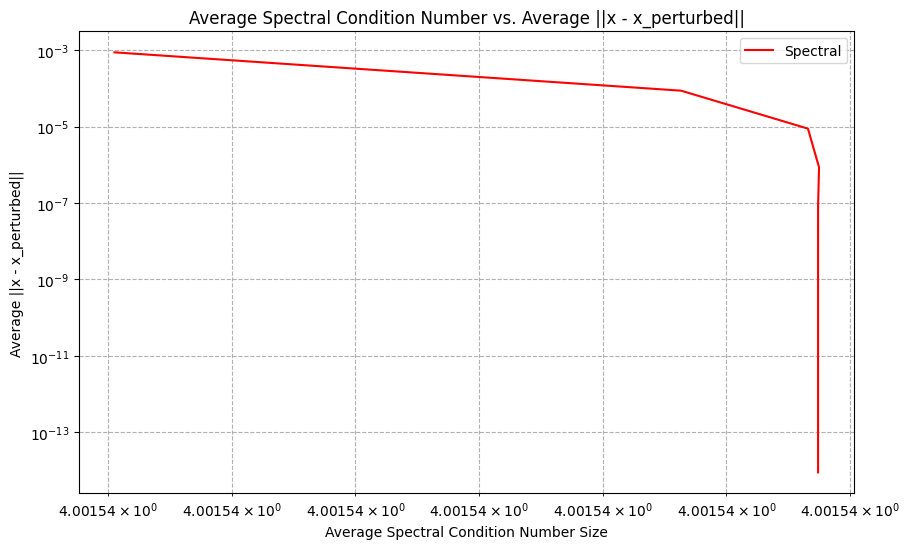

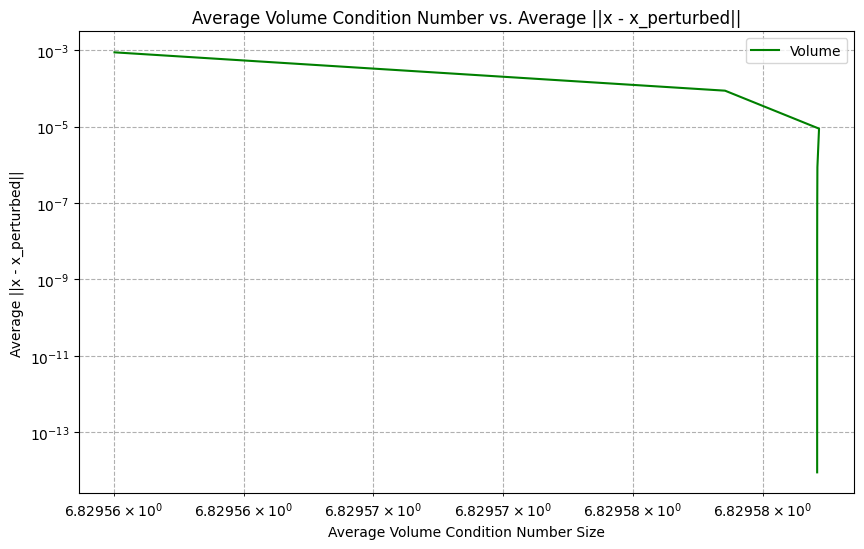

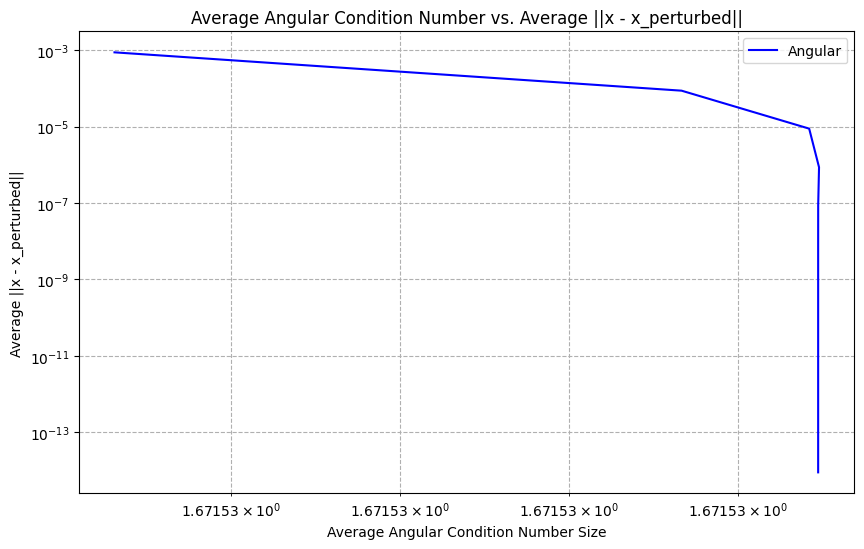

In [10]:
matrix_dimension = 30
decimal_orders = range(2, 14)
matrix_generator = generate_tridiagonal_matrix_element
num_trials = 1000

plot_experiment_results(matrix_dimension, decimal_orders, matrix_generator, num_trials)